# 05.03 - MODEL SELECTION

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import local.lib.timeseries as ts
%matplotlib inline

## <font color="red"> RULE: we cannot use the same data to BOTH make choices on our precessing pipeline AND report performance</font>

In [25]:
dataset = pd.read_csv("local/data/cal_housing.data")
dataset = dataset.sample(len(dataset))

d = dataset.iloc[:10000].sample(1000)
X = d.values[:,:-1]
y = d["medianHouseValue"].values
print (X.shape, y.shape)

(1000, 5) (1000,)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error

In [6]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

## Let's consider we are choosing between different models with any crossval technique

We start by using a regular train/test split with resampling

In [7]:
from sklearn.model_selection import cross_validate, ShuffleSplit

### MODEL 1

In [8]:
estimator1 = DecisionTreeRegressor(max_depth=5)
z1 = cross_validate(estimator1, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))

In [9]:
z1

{'fit_time': array([0.0026865 , 0.00383544, 0.0037663 , 0.00304556, 0.00305915,
        0.00277185, 0.00263572, 0.00275302, 0.00315762, 0.00289965]),
 'score_time': array([0.00101566, 0.00098491, 0.00112557, 0.00090575, 0.00094485,
        0.00083876, 0.00069666, 0.00081682, 0.00074935, 0.00079894]),
 'estimator': (DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
  DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,


In [10]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))
    
report_cv_score(z1)    

test score   0.384 (±0.0476) with 10 splits
train score  0.336 (±0.0078) with 10 splits


### MODEL 2

In [11]:
from sklearn.ensemble import RandomForestRegressor
estimator2 = DecisionTreeRegressor(max_depth=10)
z2 = cross_validate(estimator2, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))  
report_cv_score(z2)    

test score   0.367 (±0.0383) with 10 splits
train score  0.111 (±0.0113) with 10 splits


### MODEL 3

In [12]:
from sklearn.linear_model import LinearRegression
estimator3 = LinearRegression()
z3 = cross_validate(estimator3, X, y, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))
report_cv_score(z3)

test score   0.455 (±0.0233) with 10 splits
train score  0.431 (±0.0060) with 10 splits


## Some questions:

- **what would be our model of choice**: probably estimator2. **CORRECT**
- **what is the performance associated with our choice**: the test score reported by estimator2. **INCORRECT**
- we need to **physically** deliver our trained model to the appropriate business area, but we trained several models for statistical stability. **Which model shall we hand over?**


we **cannot** use the same data to make a choice AND report a result.

observe the performance measured with the models we trained before on **new production** data

In [26]:
ed = dataset[10000:].sample(1000)
eX = ed.values[:,:-1]
ey = ed["medianHouseValue"].values
print (eX.shape, ey.shape)

(1000, 5) (1000,)


In [16]:
scores = [rel_mrae(estimator, eX, ey) for estimator in z2["estimator"]]
print ("scores", scores)
print ("mean score %.3f (±%.4f) with %d splits"%(np.mean(scores), np.std(scores), len(scores)))


scores [0.34704496772017795, 0.35181627445650004, 0.3780380631512966, 0.3473043719704006, 0.3303955214044563, 0.4078152917670846, 0.3454037329742688, 0.34298337274978824, 0.3505249600341739, 0.3482397402889321]
mean score 0.355 (±0.0209) with 10 splits


### use train/val/test splits

- use train/val to train and select model
- use test split ONLY to measure performance of the selected model

literature and resources use `test`/`val` interchangeably, or sometimes `dev` instead of `val`

observe how we:

- do a first split with 10% for test and 90% for train/val
- adjust val size so that when selecting x% of 90% train/val, ends up having the same number of elements as in test

In [59]:
from sklearn.model_selection import train_test_split

test_size = 0.3
number_of_houses_for_trainval = 1000

val_size  = test_size/(1-test_size) # so that the have the same number of elements

assert number_of_houses_for_trainval<10000, "too many houses for trainval"


d = dataset.iloc[:10000].sample(number_of_houses_for_trainval)
X = d.values[:,:-1]
y = d["medianHouseValue"].values
print (X.shape, y.shape)

print ("test size %.2f"%test_size)
print ("val size is %.2f (relative to %.2f) "%(val_size, 1-test_size))

Xtv, Xts, ytv, yts = train_test_split(X, y, test_size=test_size)
print (Xtv.shape, Xts.shape)

(1000, 5) (1000,)
test size 0.30
val size is 0.43 (relative to 0.70) 
(700, 5) (300, 5)


**PART 1**: we **AUTOMATE** the model selection process

In [60]:
zscores = []
estimators = [estimator1, estimator2, estimator3]
for estimator in estimators:
    print("--")
    z = cross_validate(estimator, Xtv, ytv, return_train_score=True, return_estimator=False,
                       scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=val_size))
    report_cv_score(z)
    zscores.append(np.mean(z["test_score"]))
best = np.argmin(zscores)
print ("selecting ", best)
best_estimator = estimators[best]
print ("\nselected model")
print (best_estimator)

--
test score   0.473 (±0.0475) with 10 splits
train score  0.347 (±0.0423) with 10 splits
--
test score   0.416 (±0.0335) with 10 splits
train score  0.092 (±0.0213) with 10 splits
--
test score   0.486 (±0.0305) with 10 splits
train score  0.483 (±0.0167) with 10 splits
selecting  1

selected model
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')


**PART 2**: train selected estimator on train/val, report performance on est

In [61]:
best_estimator.fit(Xtv,ytv)
reported_performance = rel_mrae(best_estimator, Xts, yts)
print ("reported performance of selectd model %.3f"%reported_performance)

reported performance of selectd model 0.395


## monitor production

observe that even when showing **NEW** data to our selected model, performance still varies.

as we have more data kept in this dataset we **SIMULATE** we get new data batches from production.

in **SMALL DATA** performance biases are **DIFFICULT** to overcome in practice and must be monitored!!!

how much data is __small data__ depends on your problem.



In [62]:
er = []
sizes = []
for _ in range(100):
    size = len(Xts)+np.random.randint(len(Xts))-len(Xts)//2
    ed = dataset.iloc[10000:].sample(size)
    eX = ed.values[:,:-1]
    ey = ed["medianHouseValue"].values
    er.append(rel_mrae(best_estimator, eX, ey))
    sizes.append(size)

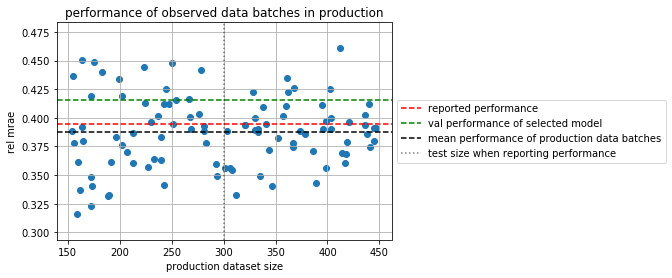

In [63]:
plt.scatter(sizes, er)
plt.xlabel("production dataset size")
plt.ylabel("rel mrae")
plt.title("performance of observed data batches in production")
plt.axhline(reported_performance, color="red", ls="--", label="reported performance")
plt.axhline(zscores[best], color="green", ls="--", label="val performance of selected model")
plt.axhline(np.mean(er), color="black", ls="--", label="mean performance of production data batches")
plt.axvline(len(Xts), color="black", alpha=.5, ls=":", label="test size when reporting performance")
plt.grid(); plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));


## suggested experiment

### change `test_size`  and `number_of_houses_for_trainval` when using train/val/test splits above

larger values might yield better stability of results
